## Test SPIM data CEBRA model

- Use CEBRA time contrastive learning on neural data from one fish
    - design model
    - convert SPIM data to usable format 
    - load data
    - fit
    - plot embeddings
    - try to decode stimulus frame (for spots only)
        - Doing this naively should fail because there won't be any change in activity on the exact frame<br/><br/>


In [1]:
import cebra
import h5py
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split

In [2]:
# # global params

# list of all data files
dat_files = ['/media/storage/DATA/lfads_export/f1_221027.h5',
             '/media/storage/DATA/lfads_export/f1_221103.h5',
             '/media/storage/DATA/lfads_export/f2_221103.h5',
             '/media/storage/DATA/lfads_export/f3_221103.h5']

global FILENAME
global TIMESTEPS
global ROIS

FILENAME = dat_files[0]
TIMESTEPS = 5000
ROIS = 10000

### Cebra time contrastive learning

### Decoding stimulus frame

In [3]:
# # design model

import cebra

cebra_time_model = cebra.CEBRA(
    model_architecture='offset10-model',
    device='cuda_if_available',
    conditional='time',
    temperature_mode='auto',
    min_temperature=0.1,
    time_offsets=10,
    max_iterations=10000,
    max_adapt_iterations=500,
    batch_size=None,
    learning_rate=1e-4,
    output_dimension=3,
    verbose=True,
    num_hidden_units=32,
    hybrid=False
    )
print(cebra_time_model)



CEBRA(conditional='time', learning_rate=0.0001,
      model_architecture='offset10-model', output_dimension=3,
      temperature_mode='auto', time_offsets=10, verbose=True)


In [4]:
# # format and load SPIM data 

# list of all data files
dat_files = ['/media/storage/DATA/lfads_export/f1_221027.h5',
             '/media/storage/DATA/lfads_export/f1_221103.h5',
             '/media/storage/DATA/lfads_export/f2_221103.h5',
             '/media/storage/DATA/lfads_export/f3_221103.h5']


# use data from one fish
filename = dat_files[0]
filename_trunc = filename.split('/')[-1][:-3] # fish and date only

# timesteps and number of rois
timesteps = 5000
rois = 10000

with h5py.File(filename, 'r') as f:
    # shape (timepoints, rois)
    dfof = f['rois']['dfof']
    print(f"Full experiment dfof dimensions: {dfof.shape}")

    # restrict data to random x neurons of the first y timesteps
    roi_index = np.sort(np.random.choice(np.arange(0,dfof.shape[1]), size=rois, replace=False))
    dfof = np.array(f['rois']['dfof'][:timesteps, roi_index])
    print(f"Restricted dfof dimensions: {dfof.shape}")

# save numpy array
np.savez(f"dfof_{filename_trunc}", neural=dfof)

# load data into cebra
neural = cebra.load_data(file=f"dfof_{filename_trunc}.npz", key="neural")



Full experiment dfof dimensions: (43350, 93122)
Restricted dfof dimensions: (5000, 10000)


In [ ]:
np.sort(np.random.choice(np.arange(0,dfof.shape[1]), size=1000, replace=False))


In [ ]:
filename.split('/')[-1][:-3]

In [5]:
# # train

cebra_time_model.fit(neural)
cebra_time_model.save(f'{filename_trunc}_time.pt')

pos:  0.3976 neg:  7.9014 total:  8.2990 temperature:  1.1301: 100%|██████████| 10000/10000 [05:23<00:00, 30.94it/s]


<Axes3D: title={'center': 'Embedding'}>

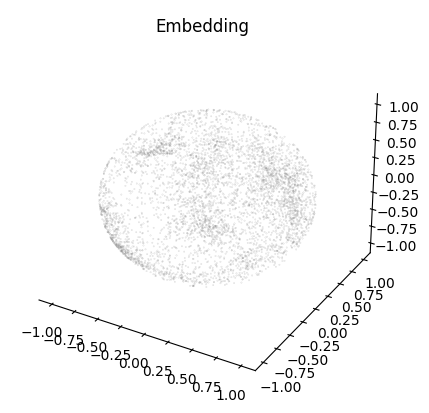

In [5]:
# # plot embeddings

output_dims = 3

cebra_time_model = cebra.CEBRA.load(f'{filename_trunc}_time.pt')
embedding = cebra_time_model.transform(neural)
cebra.plot_embedding(embedding)

assert(embedding.shape == (TIMESTEPS, output_dims))

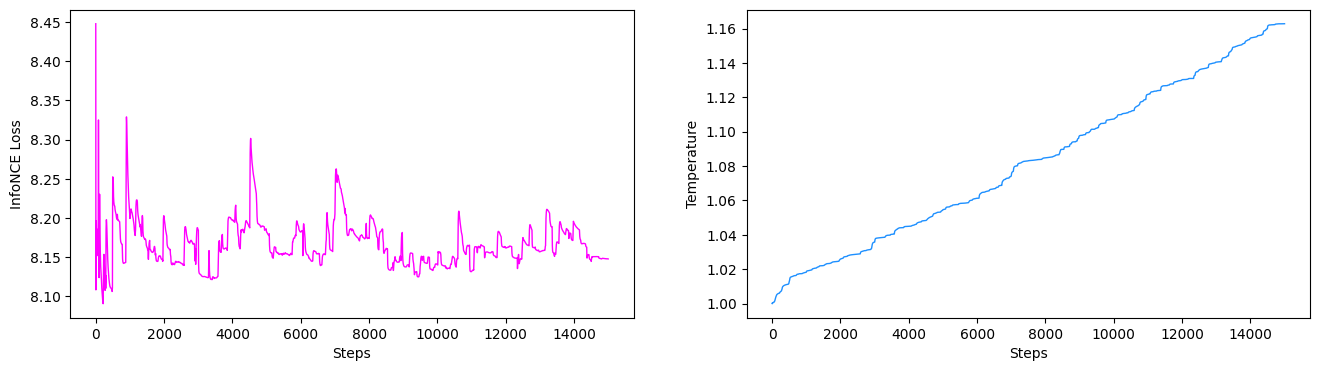

In [7]:
# # visualise training loss and temperature
fig = plt.figure(figsize=(16,4))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
ax1 = cebra.plot_loss(cebra_time_model, ax=ax1)
ax2 = cebra.plot_temperature(cebra_time_model, ax=ax2)


In [138]:
# # decode stimlus frame
# This is difficult because stimulus presentations are very rare
# Much easier to decode a continuous variable, or discrete variables with 50/50 on/off

# load stimulus onset frame
with h5py.File(FILENAME, 'r') as f:
    
    # access stims
    stims = f['visuomotor']['presentations']
    print(f"Datasets found in 'presentations': {list(stims.keys())}")

    stim_onset_frame = np.asarray(stims['onset_frame'])
    print(f"Example stim onset frames are: {stim_onset_frame[:10]}")
    print(f"Total number of stim onset frames are: {stim_onset_frame.size}")

    # find stim presentation num indexes of spot stimuli for this experiment
    spot_stimuli_indexes = np.where(
                                    np.isin(
                                            np.array(stims['stim_type']), [1,2]
                                            )       
                                    )[0]
    
    spot_stimuli_indexes_2 = np.isin(
                                    np.array(stims['stim_type']), [1,2]
                                    ).nonzero()[0]                          # <- this is cleaner
    
    print(f"Indexes of spot stim onset frames: {spot_stimuli_indexes}")
    print(f"Number of spot stim onsets: {spot_stimuli_indexes.shape}")

    # index stim frame num with spot stimulus index values
    stim_onset_frame_spots = stim_onset_frame[spot_stimuli_indexes]
    print(f"First 20 frame numbers for spot stimuli are: {stim_onset_frame_spots[:20]}")

    # truncate to only include data that the model was trained on
    stim_onset_frame_spots_trunc = stim_onset_frame_spots[stim_onset_frame_spots < TIMESTEPS]
    print(f"Number of spot stims in the first {TIMESTEPS} timesteps: {stim_onset_frame_spots_trunc.size}")
    print(f"Here are their indexes: {stim_onset_frame_spots_trunc}")

    # turn the spot stim onset frames into a discrete variable
    stim_onset_frame = np.isin(np.arange(TIMESTEPS), stim_onset_frame_spots_trunc.astype(int)).astype(int)
    print(f"Here are their indexes: {stim_onset_frame}")


# split the embedding and the stim type into train-test
(embedding_train, embedding_test,
 stim_onset_train, stim_onset_test) = train_test_split(embedding, stim_onset_frame,
                                                     test_size=0.3, shuffle=False)

# train decoder
decoder = cebra.KNNDecoder()
decoder.fit(embedding_train, stim_onset_train)

# get score and predictions on test set
score = decoder.score(embedding_test, stim_onset_test)
prediction = decoder.predict(embedding_test)

score
prediction

# identify difference between prediction and real onset frames
onset_frame_true = (stim_onset_frame==True).nonzero()[0]
onset_frame_predicted = (prediction==1).nonzero()[0]
print(f"Here are the true spot presentation frame numbers: {onset_frame_true}\nAnd "+
      f"here are the predictions: {onset_frame_predicted}")

Datasets found in 'presentations': ['is_response', 'offset_frame', 'onset_frame', 'response_latency', 'stim_type']
Example stim onset frames are: [ 798. 1103. 1368. 1558. 1963. 2418. 2608. 2933. 3238. 3548.]
Total number of stim onset frames are: 142
Indexes of spot stim onset frames: [  0   3   4   5   7   9  11  14  16  18  20  23  25  28  29  32  34  36
  38  41  43  45  48  50  51  53  55  57  58  59  61  63  65  66  69  71
  72  74  76  77  80  82  83  86  88  91  93  94  96  98 100 102 104 107
 109 111 113 115 117 119 120 123 125 126 129 130 133 135 138 140]
Number of spot stim onsets: (70,)
First 20 frame numbers for spot stimuli are: [  798.  1558.  1963.  2418.  2933.  3548.  4218.  4923.  5638.  6248.
  6683.  7588.  8263.  9123.  9583. 10378. 10928. 11528. 12078. 12798.]
Number of spot stims in the first 5000 timesteps: 8
Here are their indexes: [ 798. 1558. 1963. 2418. 2933. 3548. 4218. 4923.]
Here are their indexes: [0 0 0 ... 0 0 0]
Here are the true spot presentation fra

### Code testing


In [137]:
(prediction==1).nonzero()

(array([], dtype=int64),)

In [115]:
stim_onset_frame_spots_trunc

array([ 798., 1558., 1963., 2418., 2933., 3548., 4218., 4923.])

In [130]:
(stim_onset_train == 1).nonzero()[0]
(stim_onset_frame == 1).nonzero()[0]
train = stim_onset_frame[:3500]
test = stim_onset_frame[3500:]

(train == 1).nonzero()[0], (test ==1).nonzero()[0]

(array([ 798, 1558, 1963, 2418, 2933]), array([  48,  718, 1423]))

In [132]:
(stim_onset_train ==1).nonzero()[0], (stim_onset_test ==1).nonzero()[0]

(array([ 798, 1558, 1963, 2418, 2933]), array([  48,  718, 1423]))

In [111]:
spot_stimuli_indexes_2 == spot_stimuli_indexes

array([  0,   3,   4,   5,   7,   9,  11,  14,  16,  18,  20,  23,  25,
        28,  29,  32,  34,  36,  38,  41,  43,  45,  48,  50,  51,  53,
        55,  57,  58,  59,  61,  63,  65,  66,  69,  71,  72,  74,  76,
        77,  80,  82,  83,  86,  88,  91,  93,  94,  96,  98, 100, 102,
       104, 107, 109, 111, 113, 115, 117, 119, 120, 123, 125, 126, 129,
       130, 133, 135, 138, 140])

In [62]:
np.asarray((stim_onset_frame_spots_trunc == True)).nonzero()

(array([], dtype=int64),)

In [74]:
a = np.array([1,2,3,4])
(a>2).nonzero()

(stim_onset_frame>0).nonzero()



(array([ 798, 1103, 1368, 1558, 1963, 2418, 2608, 2933, 3238, 3548, 3813,
        4218, 4403, 4728, 4923]),)

In [46]:
stim_onset_train.shape

(1500, 3)

In [29]:
stim_onset_frame[stim_onset_frame<=TIMESTEPS]

array([ 798., 1103., 1368., 1558., 1963., 2418., 2608., 2933., 3238.,
       3548., 3813., 4218., 4403., 4728., 4923.])

In [22]:
neural.shape

(5000, 10000)